The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We read and work on a csv file containing the daily new hospitalisations from 18/03 to 02/05 in France. This is what the model fitting is going to be based on instead of confirmed cases.

In [3]:
import requests
import io

url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"

dataset = requests.get(url).content
hospitalisations = pd.read_csv(io.StringIO(dataset.decode('utf-8')), sep=";")

In [4]:
# treat the data summing over all the departments for any day
hospitalisations = hospitalisations.groupby("jour").sum()

In [5]:
bd = pd.to_datetime(hospitalisations.index)[0]
ed = pd.to_datetime(hospitalisations.index)[-1]
index_dates = pd.date_range(bd, ed)
hospitalisations.index = index_dates
hospitalisations = hospitalisations["incid_hosp"]

For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_France
- on 12/03, Macron held a speech, some measures against large gatherings, announced university closure, mild social distancing encouraged
- on 17/03, nationwide lockdown
- 24/03, lockdown measures strengthened (a bit)
- 11/04, before easter
- 13/04, after easter

All the parameters chosen in the following amount to a quick, naive application of the model to France. Delays are higher as this is hospitalisation data.

In [6]:
bd = hospitalisations.index[0] # first date with hospitalisation data available
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
new_cases_obs = hospitalisations[bd:ed].to_numpy().flatten()
print(new_cases_obs)

date_begin_data = bd
date_end_data   = ed
diff_data_sim = 30 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points, in this case, 
                   # it is very high because of usage of hospitalisation data
num_days_forecast = 16

prior_date_macron_speech = datetime.datetime(2020,3,12)
prior_date_confinement_begin =  datetime.datetime(2020,3,17)
prior_date_stronger_measures =  datetime.datetime(2020,3,24)
prior_date_before_easter = datetime.datetime(2020,4,10)
prior_date_after_easter = datetime.datetime(2020,4,13)

change_points = [dict(pr_mean_date_transient = prior_date_macron_speech,
                      pr_sigma_date_transient = 4, #reduced due to closeness to the confinement begin
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_confinement_begin,
                      pr_sigma_date_transient = 4, #reduced
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_stronger_measures,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_before_easter,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_after_easter,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1)]

[2229 1256 1540 1534 2053 2618 3166 3096 3058 3352 2685 3108 4145 4281
 3845 3627 2822 1931 2754 3277 3139 2990 3161 2044 1688 1257 1965 2415
 2084 2166 1565  890 1464 1885 1619 1410 1346  999  481  964 1321 1070
 1048  668  453  345]


In [7]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 67e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=20, 
                                               pr_median_scale_delay=0.4)
    # higher delay because of use of hospitalisation data
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [8]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 404.38:  13%|█▎        | 25899/200000 [00:55<06:15, 464.26it/s]
Convergence achieved at 25900
INFO     [pymc3.variational.inference] Convergence achieved at 25900
Interrupted at 25,899 [12%]: Average Loss = 468.27
INFO     [pymc3.variational.inference] Interrupted at 25,899 [12%]: Average Loss = 468.27
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_5_log, lambda_4_log, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset

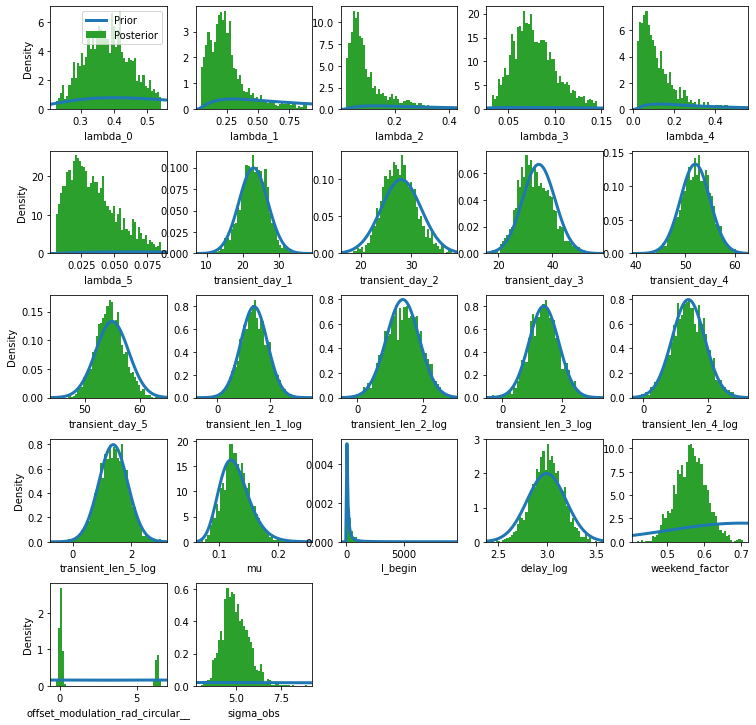

In [9]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'), lambda_exp=True)
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

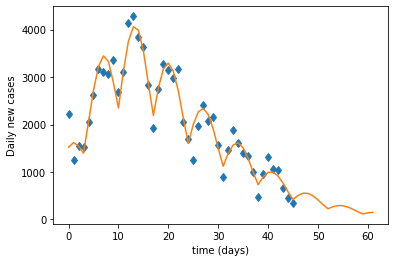

In [10]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

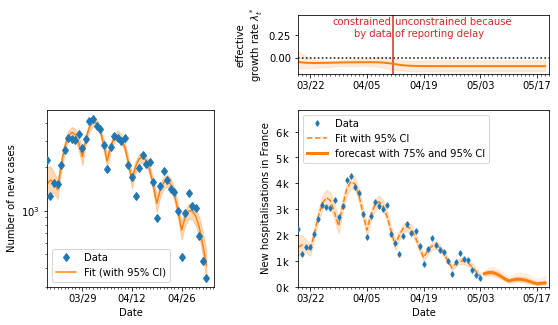

In [11]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="France", what="hospitalisations")